In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
from utils.visualize_predictions import visualize_predictions
from utils.plot_training_validation import plot_training_validation
from utils.evaluation import evaluate_model
from utils.train import train_model

In [3]:
# SETTINGS

# merged_dataset_dir = "../2_classes_merged_dataset"
merged_dataset_dir = "../3_classes_merged_dataset"

batch_size = 16
learning_rate = 0.001
num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

test_val_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# Load the entire dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=merged_dataset_dir, transform=train_transform)

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the sizes of each split
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # Ensures all samples are used

# Ensure reproducibility by setting a manual seed
torch.manual_seed(42)

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Ensures reproducible splits
)

# Apply different transforms to validation and test datasets
# Since random_split returns Subset objects, we need to set the transform manually
# To do this, we override the transform attribute for val and test
# Access the underlying dataset with train_dataset.dataset
val_dataset = Subset(
    datasets.ImageFolder(root=merged_dataset_dir, transform=test_val_transform),
    val_dataset.indices
)

test_dataset = Subset(
    datasets.ImageFolder(root=merged_dataset_dir, transform=test_val_transform),
    test_dataset.indices
)

# Create DataLoaders for each split
num_workers = 8  # Adjust based on your system's capabilities

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle for training
    num_workers=num_workers,
    pin_memory=True  # Speeds up data transfer to GPU if using CUDA
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle for validation
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle for testing
    num_workers=num_workers,
    pin_memory=True
)

# Optional: Print dataset sizes for verification
print(f"\nTotal samples: {total_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")



Total samples: 4479
Training samples: 3583
Validation samples: 447
Test samples: 449


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 9 * 9, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolution + BN + ReLU + Pool layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # raw logits (no softmax)
        return x

In [6]:
model = SimpleCNN(num_classes=len(full_dataset.classes)).to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


In [8]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    gradient_clip=1.0,
    print_interval=10,
    save_dir="../saved_models/cnn",
    save_best=True,
    save_every_epoch=False,
)


Epoch 1/3 - Rozpoczynam trening:


Epoch 1: Train Loss: 1.2358 | Train Acc: 51.86%
Epoch 1 - Rozpoczynam walidację:


Walidacja:  61%|██████    | 17/28 [00:16<00:04,  2.59it/s]

Walidacja: Batch 10/28, Loss: 0.9704
Walidacja: Batch 20/28, Loss: 1.0883


Walidacja:  86%|████████▌ | 24/28 [00:16<00:00,  4.17it/s]

Walidacja: Batch 28/28, Loss: 0.9048


c:\Users\kubia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1: Val Loss: 0.9054 | Val Acc: 55.70%
Najlepszy model zapisany: ./saved_models_cnn\best_model.pth

Epoch 2/3 - Rozpoczynam trening:


Epoch 2: Train Loss: 0.8178 | Train Acc: 60.01%
Epoch 2 - Rozpoczynam walidację:


Walidacja:  79%|███████▊  | 22/28 [00:17<00:01,  3.11it/s]

Walidacja: Batch 10/28, Loss: 0.8234
Walidacja: Batch 20/28, Loss: 0.8458


Walidacja: 100%|██████████| 28/28 [00:17<00:00,  4.41it/s]

Walidacja: Batch 28/28, Loss: 0.7545


Epoch 2: Val Loss: 0.7862 | Val Acc: 63.53%
Najlepszy model zapisany: ./saved_models_cnn\best_model.pth

Epoch 3/3 - Rozpoczynam trening:


Epoch 3: Train Loss: 0.7525 | Train Acc: 63.75%
Epoch 3 - Rozpoczynam walidację:


Walidacja:  50%|█████     | 14/28 [00:17<00:12,  1.10it/s]

Walidacja: Batch 10/28, Loss: 0.7753
Walidacja: Batch 20/28, Loss: 0.4546


Walidacja:  96%|█████████▋| 27/28 [00:17<00:00,  2.53it/s]

Walidacja: Batch 28/28, Loss: 0.6426


Epoch 3: Val Loss: 0.6655 | Val Acc: 67.11%
Najlepszy model zapisany: ./saved_models_cnn\best_model.pth

Trening zakończony.


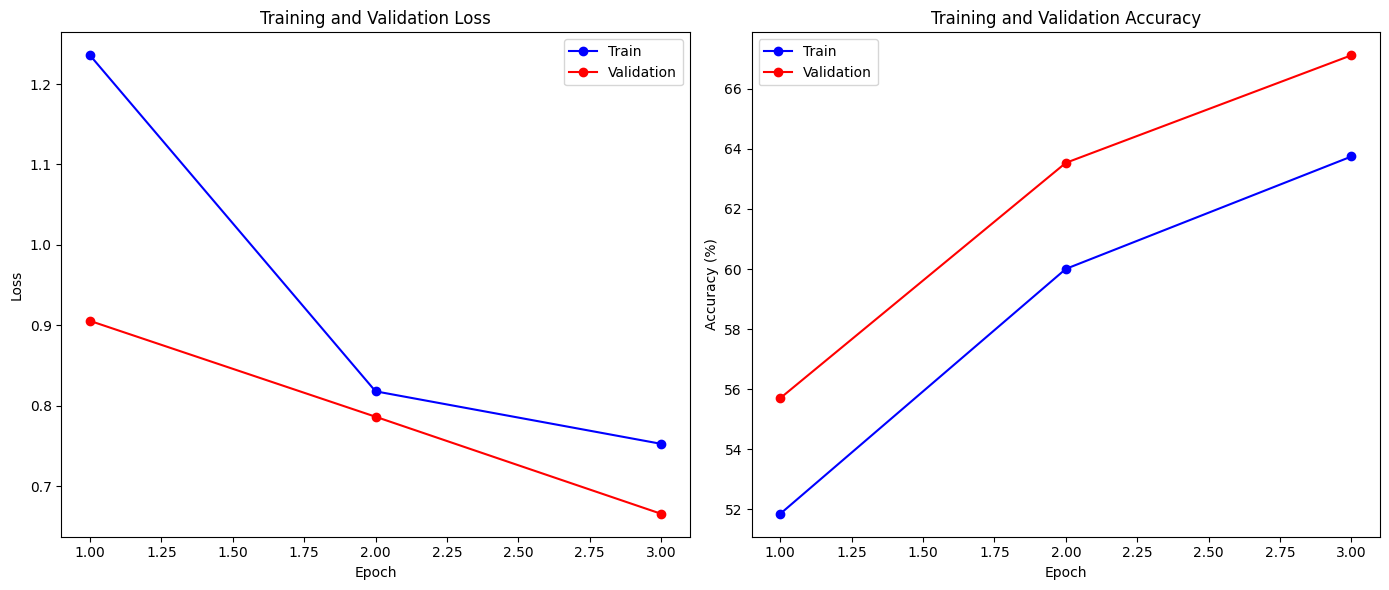

In [9]:
plot_training_validation(
    history["train_loss"], history["val_loss"], history["train_acc"], history["val_acc"]
)


Test Loss: 0.5785 | Test Accuracy: 0.7283



Raport klasyfikacji:
               precision    recall  f1-score   support

   BACTERIAL       0.63      0.85      0.73       150
      NORMAL       0.84      0.95      0.89       151
       VIRAL       0.75      0.38      0.50       148

    accuracy                           0.73       449
   macro avg       0.74      0.73      0.71       449
weighted avg       0.74      0.73      0.71       449


Macierz konfuzji:
[[128  10  12]
 [  1 143   7]
 [ 74  18  56]]


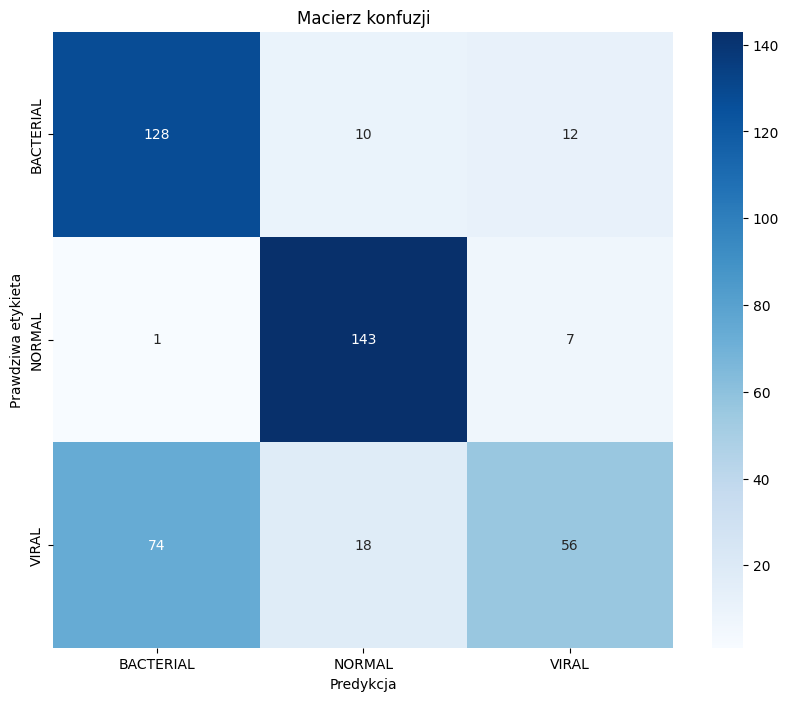

In [10]:
class_names = test_dataset.dataset.classes
evaluate_model(model, test_loader, criterion, device, class_names)

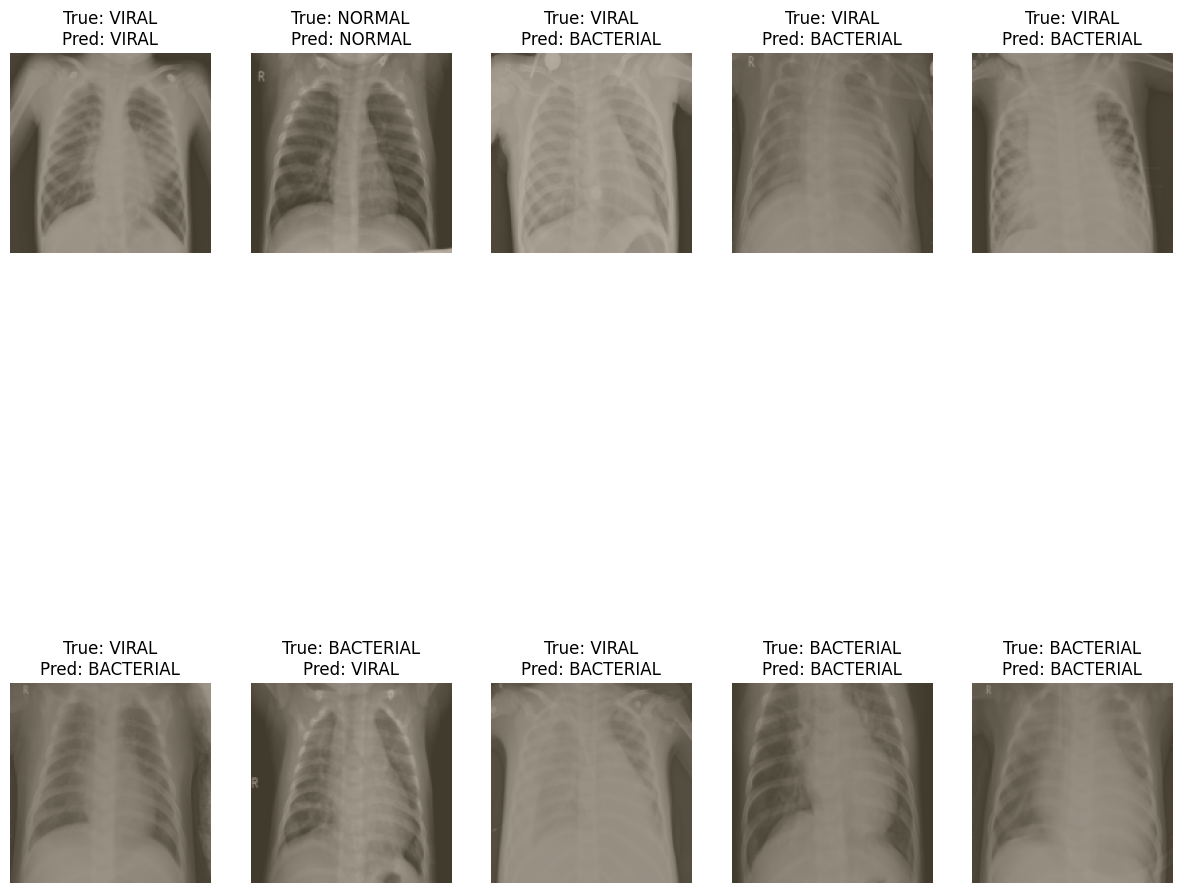

In [11]:
visualize_predictions(model, test_loader, test_dataset.dataset.classes, device, num_images=10)